In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import mpl_toolkits.mplot3d as mplot3d

import skimage as sk
import skimage.feature as skfeature
import skimage.filters as skfilters
import skimage.segmentation as sksegmentation 
import skimage.color as skcolor
import skimage.measure as skmeasure
import skimage.morphology as skmorph
import skimage.exposure as skexposure

import sklearn.cluster as sk2cluster

# Utilities

In [161]:
Transparency = True
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def read_image(index, dir_t):
    filename = "data/{t}/{i}.jpg".format(t = dir_t, i=index)    
    img = plt.imread(filename)
    return img

# Compiling Skin Color Datasets

In [138]:
def sfa_dataset(dir_t, n_images = 3354):
    d = 35**2
    colors = np.zeros((n_images*d, 3));

    for i in range(0,n_images):
        tuna = read_image(i+1, dir_t).reshape(d,3)
        j,k = i*d, i*d+d
        colors[j:k] = tuna
    
    colors = rgb2ycbcr(colors.reshape(n_images,d,3)).reshape(n_images*d, 3)[:,1:]

    return colors

# Skin Likelihood image

In [139]:
def get_mean(data):
     return np.mean(data, axis=0)

def get_covariance(data):
    return np.cov(data.T)

def likelihoods(x, mean, cov):
    x = x-mean
    
    X = np.matmul(x[:], np.linalg.inv(cov))
    X = np.sum(X*x, axis = 1)
    
    return np.exp(-0.5*X)
    
def skl_image(img , mean, cov):
    r,c,d = img.shape
    x = img.reshape(r*c,d)[:,:mean.shape[0]]
    
    L = likelihoods(x, mean , cov)
    
    return L.reshape(r,c)


# Proposed method

1. ### Dataset

In [140]:
data = sfa_dataset('skin')
data.shape

(4108650, 2)

2. ### SFA Color distribution

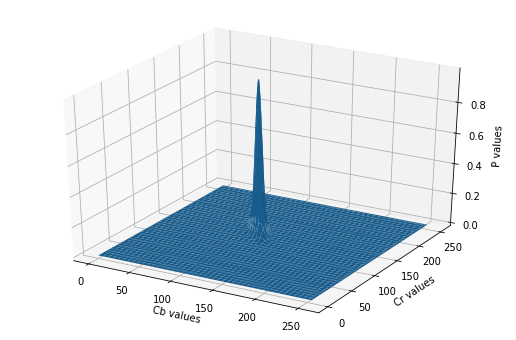

In [141]:
def demo1(data):
    mean = get_mean(data)
    cov = get_covariance(data)
    
    Cb = np.arange(256)
    Cr = np.arange(256)
    Cb, Cr = np.meshgrid(Cb, Cr)
    
    X = np.zeros((256,256, 2))
    X[:,:,0] = Cb
    X[:,:,1] = Cr
    
    L = skl_image(X, mean, cov)
    
    fig = plt.figure(figsize = (9,6))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(Cb, Cr, L, linewidth=0, antialiased=True)
    ax.set_xlabel('Cb values')
    ax.set_ylabel('Cr values')
    ax.set_zlabel('P values')
    
    plt.savefig('results/demo1.png', transparent = Transparency)

demo1(data)

3. ### Unsupervised Segmentation

In [142]:
def kmeans(image, k):
    """
    kmeans segmentation
    """
    dx,dy,dz= image.shape
    data = np.zeros((dx*dy,dz))
    data = image.reshape(dx*dy,dz)
    
    kmeans = sk2cluster.KMeans(n_clusters=k, max_iter = 1000).fit(data)
    plabels = kmeans.predict(data)
    pimg = kmeans.cluster_centers_[plabels].reshape(dx,dy,dz).astype(int)
    
    return pimg, k

def slic(image, k):
    """
    superpixel segmentation
    """
    out = sksegmentation.slic(image, n_segments=k, compactness=10, sigma=3, multichannel = True)
    k = np.unique(out).size
    out = skcolor.label2rgb(out, image, kind='avg')
    
    return out,k

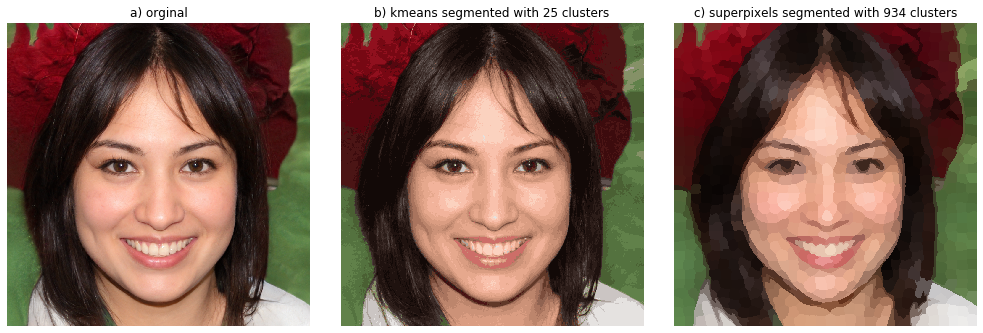

In [143]:
def demo2():
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (7*2,7*2))


    img1 = read_image(1, 'test')
    img2,_ = kmeans(img1, 30)
    img3,k = slic(img1, 1000)
    imgs = [img1, img2, img3]
    
    titles = [
        'a) orginal',
        'b) kmeans segmented with 25 clusters',
        'c) superpixels segmented with '+str(k)+' clusters'
    ]
    
    for j in range(3):
        axes[j].axis("off")
        axes[j].imshow(imgs[j])
        axes[j].set_title(titles[j])
    
    plt.savefig('results/demo2.png', transparent = Transparency)
    fig.tight_layout()
    
    return imgs
    

test_imgs = demo2()

4. ### Skin Segmentation

In [144]:
def skin_segmentation(img, mean, cov):
    img = rgb2ycbcr(img)

    # apply skin color model
    img = skl_image(img[:,:,1:], mean, cov)
    img = skfilters.gaussian(img, sigma=2)
    img = skmorph.opening(img, skmorph.disk(3))

    # thresholding
    thresh = skfilters.threshold_otsu(img)
    img = skmorph.closing(img > thresh, skmorph.square(3))

    # add edges to sharppern things up
    img += skfeature.canny(img, sigma=3)
    
    return img

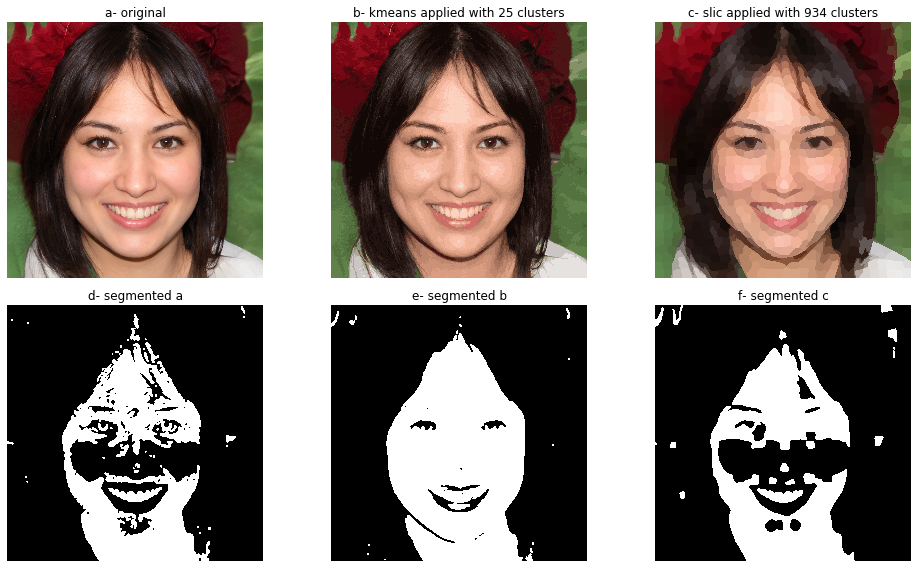

In [149]:
def demo3(images, data):
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (7*2,8))
    
    imgs = [None, None, None]
    
    mean = get_mean(data)
    cov  = get_covariance(data)
    
    titles = [
        ['a- original', 'b- kmeans applied with 25 clusters', 'c- slic applied with 934 clusters'],
        ['d- segmented a', 'e- segmented b', 'f- segmented c']
    ]
    
    for j in range(3):
        imgs[j] = skin_segmentation(images[j], mean, cov)
        
        axes[0][j].axis("off")
        axes[0][j].imshow(images[j])
        axes[0][j].set_title(titles[0][j])
        
        axes[1][j].axis("off")
        axes[1][j].imshow(imgs[j] ,cmap = 'gray')
        axes[1][j].set_title(titles[1][j])
        
    plt.savefig('results/demo3.png', transparent = Transparency)
    fig.tight_layout()
    return imgs

seg_imgs = demo3(test_imgs, data)

5. ### Post processing 

In [ ]:
def postprocessing(img):
    
    # find the connected components
    plabels = skmorph.label(img)
     
    # region cuptoff heuristic
    areas = []
    for region in skmeasure.regionprops(plabels):
        areas.append(region.area)
    
    area_cutoff = np.max(np.array(areas))*0.05
    
    #remove small components
    for region in skmeasure.regionprops(plabels):
        if region.area <= area_cutoff:
            minr, minc, maxr, maxc = region.bbox
            img[minr:maxr,minc:maxc] = 0
    
    # border patches
    rects = []
    for region in skmeasure.regionprops(plabels):
        if region.area >= area_cutoff:
            minr, minc, maxr, maxc = region.bbox
            rects.append(
                mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                   fill=False, edgecolor='red', linewidth=2)
            )
    
    return img, rects

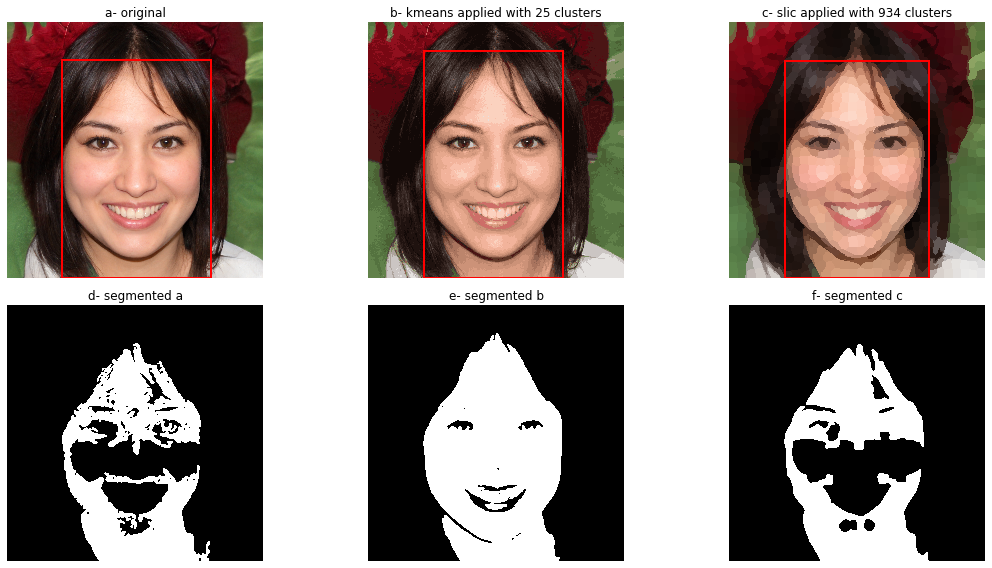

In [150]:
def demo4(imgs1, imgs2):
    fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (8*2,8))
    
    titles = [
        ['a- original', 'b- kmeans applied with 25 clusters', 'c- slic applied with 934 clusters'],
        ['d- segmented a', 'e- segmented b', 'f- segmented c']
    ]
    
    for j in range(3):
        img, borders = postprocessing(imgs2[j]) 
        
        axes[0][j].axis("off")
        axes[0][j].imshow(imgs1[j])
        axes[0][j].set_title(titles[0][j])
        for b in borders: axes[0][j].add_patch(b)
        
        axes[1][j].axis("off")
        axes[1][j].imshow( img ,cmap = 'gray')
        axes[1][j].set_title(titles[1][j])
        
    
    plt.savefig('results/demo4.png', transparent = Transparency)
    fig.tight_layout()
    
demo4(test_imgs, seg_imgs)

# Results

In [155]:
def demo5(batch, data):
    fig, axes = plt.subplots(nrows = 6, ncols = 3, figsize = (16,8*3))
    
    ids = 3*batch+1
    
    mean = get_mean(data)
    cov  = get_covariance(data)
    
    imgs = [None, None, None]
         
    for i in range(3):
        imgs[0] = read_image(ids+i, 'test')
        imgs[1],_ = kmeans(imgs[0], 30)
        imgs[2],_ = slic(imgs[0], 1000)
                
        for j in range(3):
            res = skin_segmentation(imgs[j], mean, cov)
            res,_ = postprocessing(res) 
            
            axes[i*2][j].axis("off")
            axes[i*2][j].imshow(imgs[j], 'gray')
            
            axes[i*2+1][j].axis("off")
            axes[i*2+1][j].imshow(res, 'gray')
    
    plt.savefig('results/demo5.'+str(batch+1)+'.png', transparent = Transparency)
    fig.tight_layout()
    plt.close()


In [156]:
demo5(0, data)
demo5(1, data)
demo5(2, data)

In [157]:
def background_removal(img):
    img = sk.img_as_float(img)
    
    seed = np.copy(img)
    seed[1:-1, 1:-1] = img.min()
    mask = img

    img = (img - skmorph.reconstruction(seed, mask, method='dilation'))*255
    
    return img.astype(int)


def background_removal2(img):
    dx,dy,dz = img.shape
    
    s = np.linspace(0, 2*np.pi, 400)
    r = dx/2 + (dx/2)*np.sin(s)
    c = dy/2 + (dy/2)*np.cos(s)
    
    init = np.array([r, c]).T
    snake = sksegmentation.active_contour(skfilters.gaussian(img, 3, multichannel = False),
                       init, alpha=0.015, beta=10, gamma=0.001, coordinates = 'rc')
    
    return snake,init

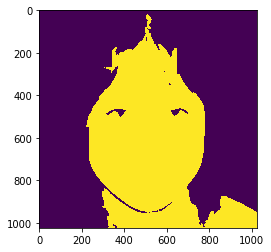

In [168]:
def skin_segmentation_final(img, seg = None, segK = 10):
    res = img.copy()
    
    if seg != None:
        res,_ = seg(img, segK)
    
    SFA_DATASET = sfa_dataset('skin')
    
    mean = get_mean(SFA_DATASET)
    cov = get_covariance(SFA_DATASET)
    res = skin_segmentation(res, mean, cov)
    
    res,_ = postprocessing(res)
    
    return res
    
img = read_image(1, 'test')
img2 = skin_segmentation_final(img, kmeans)
plt.imshow(img2)